In [ ]:
# default_exp bap_mixture_models

# bap_mixture_models

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import scipy.stats as stats

In [ ]:
%matplotlib inline

#### Data

Text(0.5, 0, '$x$')

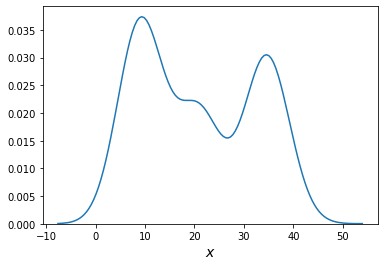

In [ ]:
clusters = 3
n_cluster = [90, 50, 75]
n_total = sum(n_cluster)
means = [9, 21, 35]
std_devs = [2, 2, 2]
mix = np.random.normal(np.repeat(means, n_cluster), np.repeat(std_devs, n_cluster))

sns.kdeplot(np.array(mix))
plt.xlabel('$x$', fontsize=14)

#### Model

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  # This is added back by InteractiveShellApp.init_path()
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>ElemwiseCategorical: [category]
>CompoundStep
>>Metropolis: [p]
>>Metropolis: [sd]
>>Metropolis: [means]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 45 seconds.
The number of effective samples is smaller than 10% for some parameters.


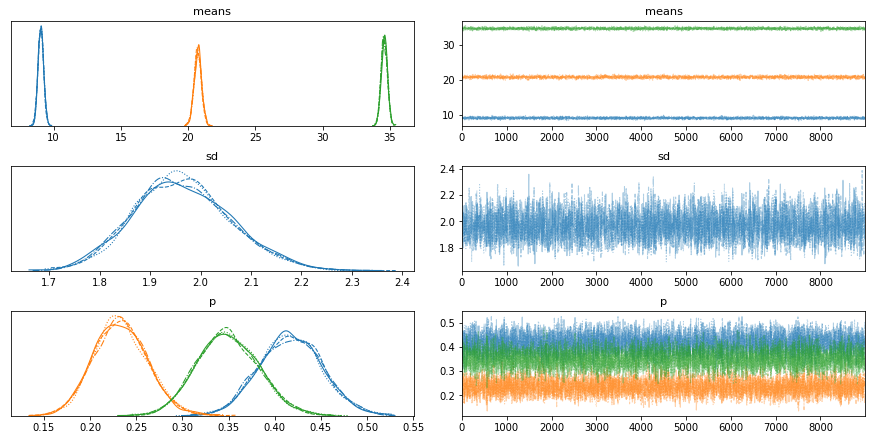

In [ ]:
with pm.Model() as model_ug:
    p = pm.Dirichlet("p", a=np.ones(clusters))
    category = pm.Categorical('category', p=p, shape=n_total)
    
    means = pm.Normal('means', mu=[10, 20, 30], sd=2, shape=clusters)
    sd = pm.HalfCauchy('sd', 5)
    
    y = pm.Normal('y', mu=means[category], sd=sd, observed=mix)
    
    
    step1 = pm.ElemwiseCategorical(vars=[category], values=range(clusters))
    step2 = pm.Metropolis(vars=[means, sd, p])
    trace_ug = pm.sample(10000, step=[step1, step2])
    chain_ug = trace_ug[1000:]
    varnames = ['means','sd','p']
    pm.traceplot(chain_ug, varnames)

In [ ]:
az.summary(chain_ug, varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],9.058,0.204,8.674,9.439,0.003,0.002,3638.0,3633.0,3636.0,4409.0,1.0
means[1],20.729,0.273,20.242,21.268,0.005,0.004,2662.0,2662.0,2665.0,3714.0,1.0
means[2],34.595,0.227,34.164,35.014,0.004,0.003,3114.0,3114.0,3120.0,3974.0,1.0
sd,1.965,0.095,1.789,2.147,0.002,0.001,3523.0,3514.0,3543.0,3986.0,1.0
p[0],0.417,0.034,0.356,0.482,0.000,0.000,4811.0,4811.0,4812.0,5801.0,1.0
p[1],0.233,0.029,0.181,0.288,0.000,0.000,4247.0,4211.0,4258.0,4887.0,1.0
p[2],0.349,0.033,0.289,0.411,0.001,0.000,3783.0,3711.0,3823.0,4530.0,1.0


#### Plot model samples

/home/jovyan/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Text(0.5, 0, '$x$')

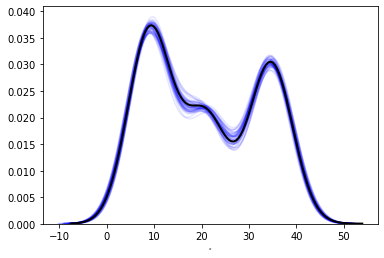

In [ ]:
ppc = pm.sample_posterior_predictive(chain_ug, 50, model_ug)
for i in ppc['y']:
    sns.kdeplot(i, alpha=0.1, color='b')
    
sns.kdeplot(np.array(mix), lw=2, color='k')
plt.xlabel('$x$', fontsize=4)

### 2. Marginalized Gaussian mixture model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sd]
>Metropolis: [means]
>Metropolis: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 7 seconds.
The number of effective samples is smaller than 10% for some parameters.


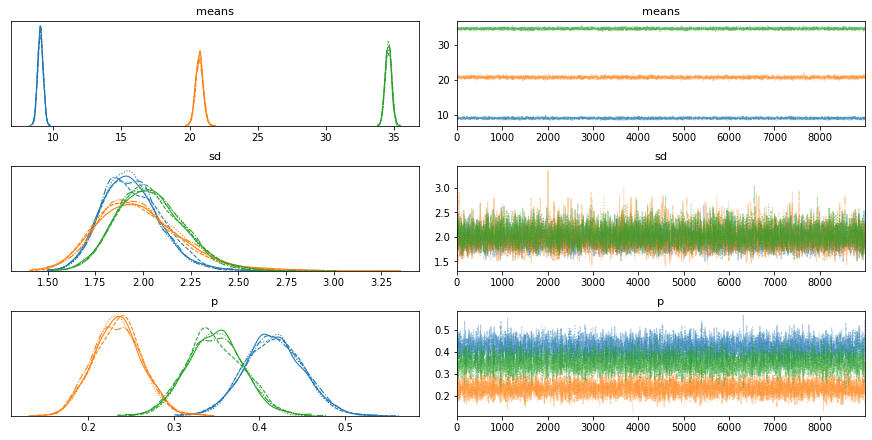

In [ ]:
with pm.Model() as model_mg:
    p = pm.Dirichlet("p", a=np.ones(clusters))
    means = pm.Normal('means', mu=[10, 20, 30], sd=2, shape=clusters)
    sd = pm.HalfCauchy('sd', 5, shape=clusters)
    
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=mix)
    
    step = pm.Metropolis()
    trace_mg = pm.sample(10000, step)
    chain_mg = trace_mg[1000:]
    varnames = ['means','sd','p']
    pm.traceplot(chain_mg, varnames)

In [ ]:
az.summary(chain_mg, varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],9.054,0.202,8.672,9.423,0.004,0.003,3129.0,3129.0,3127.0,4624.0,1.0
means[1],20.714,0.276,20.198,21.227,0.005,0.004,2520.0,2520.0,2525.0,3578.0,1.0
means[2],34.591,0.231,34.139,34.998,0.004,0.003,3480.0,3480.0,3481.0,4276.0,1.0
sd[0],1.940,0.150,1.684,2.239,0.003,0.002,3377.0,3371.0,3413.0,4679.0,1.0
sd[1],1.981,0.212,1.615,2.381,0.004,0.003,2217.0,2174.0,2307.0,2931.0,1.0
sd[2],2.038,0.169,1.743,2.367,0.003,0.002,3131.0,3131.0,3144.0,4616.0,1.0
p[0],0.417,0.033,0.357,0.481,0.001,0.000,4345.0,4345.0,4357.0,5516.0,1.0
p[1],0.234,0.028,0.182,0.286,0.000,0.000,3914.0,3914.0,3922.0,4780.0,1.0
p[2],0.349,0.032,0.290,0.409,0.001,0.000,3806.0,3806.0,3813.0,4923.0,1.0


/home/jovyan/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Text(0.5, 0, '$x$')

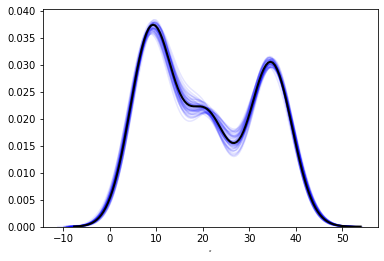

In [ ]:
ppc = pm.sample_posterior_predictive(chain_ug, 50, model_ug)
for i in ppc['y']:
    sns.kdeplot(i, alpha=0.1, color='b')
    
sns.kdeplot(np.array(mix), lw=2, color='k')
plt.xlabel('$x$', fontsize=4)

### 3. Mixture models and count data

##### Poisson distribution

Text(0, 0.5, 'pmf(k)')

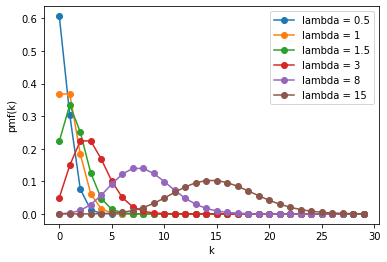

In [ ]:
lam_params = [0.5, 1, 1.5, 3, 8, 15]
k = np.arange(0, 30)

for lam in lam_params:
    y = stats.poisson(lam).pmf(k)
    plt.plot(k, y, 'o-', label=f"lambda = {lam}")
plt.legend()
plt.xlabel('k')
plt.ylabel('pmf(k)')